In [1]:
# python peripherals
import sys
from pathlib import Path
from typing import Callable, Optional
sys.path.append('../../.')

# numpy
import numpy

# torch
import torch

# matplotlib
import matplotlib
import matplotlib.pyplot
import matplotlib.axes
matplotlib.pyplot.rcParams['text.usetex'] = True

# deep-signature
from deep_signature.core.base import SeedableObject
from deep_signature.manifolds.planar_curves.implementation import PlanarCurvesManager, PlanarCurve
from deep_signature.manifolds.planar_curves.groups import EuclideanGroup, SimilarityGroup, EquiaffineGroup, AffineGroup
from deep_signature.core import discrete_distributions
from deep_signature.training import datasets
from deep_signature.training.networks import DeepSignaturesNet
from deep_signature.training.activations import Sine
from deep_signature.manifolds.planar_curves.evaluation import PlanarCurvesApproximatedSignatureComparator, PlanarCurvesShapeMatchingEvaluator
from deep_signature.manifolds.planar_curves.groups import EquiaffineGroup

SeedableObject.set_seed(seed=42)

C:\Users\Roy\miniconda3\envs\deep-signature\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
planar_curves_manager_smooth = PlanarCurvesManager(curves_file_paths=[Path("C:/deep-signature-data/curves/train/curves.npy")])
# circles = PlanarCurvesManager(curves_file_paths=[Path("C:/deep-signature-data-new/circles/train/2023-01-07-17-48-39/curves.npy")])

In [3]:
collection_name = 'basketball'
group_name = 'affine'
benchmark_1_0 = PlanarCurvesManager(curves_file_paths=[Path(f"C:/deep-signature-data-new/curves/benchmark/2023-01-07-10-12-19/{collection_name}/{group_name}/10/1_0/curves.npy")])
benchmark_0_9 = PlanarCurvesManager(curves_file_paths=[Path(f"C:/deep-signature-data-new/curves/benchmark/2023-01-07-10-12-19/{collection_name}/{group_name}/10/0_9/curves.npy")])
benchmark_0_8 = PlanarCurvesManager(curves_file_paths=[Path(f"C:/deep-signature-data-new/curves/benchmark/2023-01-07-10-12-19/{collection_name}/{group_name}/10/0_8/curves.npy")])
benchmark_0_7 = PlanarCurvesManager(curves_file_paths=[Path(f"C:/deep-signature-data-new/curves/benchmark/2023-01-07-10-12-19/{collection_name}/{group_name}/10/0_7/curves.npy")])
benchmark_0_6 = PlanarCurvesManager(curves_file_paths=[Path(f"C:/deep-signature-data-new/curves/benchmark/2023-01-07-10-12-19/{collection_name}/{group_name}/10/0_6/curves.npy")])
benchmark_0_5 = PlanarCurvesManager(curves_file_paths=[Path(f"C:/deep-signature-data-new/curves/benchmark/2023-01-07-10-12-19/{collection_name}/{group_name}/10/0_5/curves.npy")])

In [4]:
planar_curves_smooth = planar_curves_manager_smooth.planar_curves
planar_curves_smooth = sorted(planar_curves_smooth, key=lambda x: x.points.shape[0])

# figsize=(40, 40)
# # figsize=(10, 10)
# nrows = 10
# ncols = 10
# start = 96200
# fig, ax = matplotlib.pyplot.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
# for i, curve in enumerate(planar_curves_smooth[start:start + (nrows * ncols)]):
#     # print(f'CURVE INDEX: {i}. points_count: {curve.points_count}')
#     curve.plot_scattered_curve(ax=ax[i // nrows, i % nrows], cmap=None, color='#FF0000', point_size=2, label_size=5)
#     ax[i // nrows, i % nrows].set_title(f'Curve {start + i}')
#
# matplotlib.pyplot.show()
# matplotlib.pyplot.close(fig)

In [5]:
# circles_new = []
# min_radius = 25
# max_radius = 50
# sampling_density = 3
# for _ in range(20):
#     radius = float(numpy.random.uniform(low=min_radius, high=max_radius, size=1))
#     circumference = 2 * radius * numpy.pi
#     points_count = int(numpy.round(sampling_density * circumference))
#     radians_delta = 2 * numpy.pi / points_count
#     pointer = numpy.array([radius, 0])
#     circle = numpy.empty((points_count, 2))
#     pointer_curve = PlanarCurve(points=pointer, closed=False)
#     for i in range(points_count):
#         circle[i] = pointer_curve.rotate_curve(radians=i * radians_delta).points
#
#     circles_new.append(PlanarCurve(points=circle, closed=True))

In [6]:
supporting_points_count = 14
sample_points = 2 * supporting_points_count + 1
sampling_ratio = 1
multimodality = 10

In [7]:
create_activation_fn: Callable[[int], torch.nn.Module] = lambda out_features_size: Sine()
create_batch_norm_fn: Callable[[int], torch.nn.Module] = lambda out_features_size: torch.nn.BatchNorm1d(num_features=out_features_size)
# model_file_path = "C:/deep-signature-data-new/training/2023-01-03-13-40-21/models/model_375.pt"
# model_file_path = "C:/deep-signature-data-new/training/2023-01-05-15-42-57/models/model_300.pt"
# model_file_path = "C:/deep-signature-data-new/training/2023-01-06-19-05-56/models/model_725.pt"
# model_file_path = "C:/deep-signature-data-new/training/2023-01-08-10-32-10/models/model_175.pt"

# best equiaffine
# model_file_path = "C:/deep-signature-data-new/training/2023-01-08-15-06-32/models/model_950.pt"

# model_file_path = "C:/deep-signature-data-new/training/2023-01-10-05-20-03/models/model_950.pt"
model_file_path = "C:/deep-signature-data-new/training/2023-01-12-08-13-54/models/model_2325.pt"

device = torch.device('cpu')
model = DeepSignaturesNet(sample_points=sample_points, in_features_size=128, out_features_size=2, hidden_layer_repetitions=3, create_activation_fn=create_activation_fn, create_batch_norm_fn=create_batch_norm_fn, dropout_p=None)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_file_path))
model.eval()
model.cpu()

DataParallel(
  (module): DeepSignaturesNet(
    (_regressor): Sequential(
      (0): Linear(in_features=58, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Sine()
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Sine()
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Sine()
      (9): Linear(in_features=128, out_features=64, bias=True)
      (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Sine()
      (12): Linear(in_features=64, out_features=64, bias=True)
      (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): Sine()
      (15): Linear(in_features=64, out_features=64, bias

In [8]:
# fig = matplotlib.pyplot.figure(figsize=(10, 10))
#
# ax1 = fig.add_subplot(4,3,1)
# ax2 = fig.add_subplot(4,3,2)
# ax3 = fig.add_subplot(4,3,3)
# ax4 = fig.add_subplot(4,3,(4,6))
# ax5 = fig.add_subplot(4,3,(7,9))
# ax6 = fig.add_subplot(4,3,(10,12))
# # ax3 = fig.add_subplot(3,1,3)
# # ax4 = fig.add_subplot(10,1,5)
# # ax3= fig.add_subplot(3,3,4)
# # ax4= fig.add_subplot(3,3,5)
# # ax5= fig.add_subplot(3,3,7)
# # ax6= fig.add_subplot(3,3,8)
#
# # ax7= fig.add_subplot(2,3,3)
# # ax8= fig.add_subplot(2,3,6)
# # fig.tight_layout()
# matplotlib.pyplot.show()

In [12]:
def handle_signature_comparison_plot(curve1: PlanarCurve, axiomatic: bool, file_name: str, point_size: int, label_size: int, x_axis_title_size: int, y_axis_title_size: int, line_width: int, color1: str, color2: str, curve2: Optional[PlanarCurve] = None, compare_only_signature_curve: bool = False, reference_curve: Optional[PlanarCurve] = None):
    figsize=(40, 40)

    fig = matplotlib.pyplot.figure(figsize=figsize)
    ax4 = fig.add_subplot(4,3,(4,6))
    ax5 = fig.add_subplot(4,3,(7,9))
    ax6 = fig.add_subplot(4,3,(10,12))
    signature_axes = [ax4, ax5, ax6]
    if curve2 is None:
        ax1 = fig.add_subplot(4,3,(1,3))
        if reference_curve is not None:
            reference_curve.plot_scattered_curve(ax=ax1, cmap=None, color='#000000', point_size=point_size, label_size=label_size)
        curve1.plot_scattered_curve(ax=ax1, cmap='hsv', point_size=point_size, label_size=label_size)
        curve1.plot_signature(model=model, supporting_points_count=supporting_points_count, device=device, ax=signature_axes, multicolor=True, line_style='-', marker='', label_size=label_size, line_width=line_width, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, axiomatic=axiomatic)
    else:
        ax1 = fig.add_subplot(4,3,1)
        ax2 = fig.add_subplot(4,3,2)
        ax3 = fig.add_subplot(4,3,3)
        curve1.plot_scattered_curve(ax=ax1, color=color1, cmap=None, point_size=point_size, label_size=label_size)
        curve2.plot_scattered_curve(ax=ax2, color=color2, cmap=None, point_size=point_size, label_size=label_size)
        curve1.plot_scattered_curve(ax=ax3, color=color1, cmap=None, point_size=point_size, label_size=label_size)
        curve2.plot_scattered_curve(ax=ax3, color=color2, cmap=None, point_size=point_size, label_size=label_size)
        curve1.plot_signature_comparison(
            comparison_curve=curve2,
            model=model,
            supporting_points_count=supporting_points_count,
            device=device,
            ax=signature_axes,
            multicolor=False,
            line_style='-',
            marker='',
            color1=color1,
            color2=color2,
            label_size=label_size,
            line_width=line_width,
            x_axis_title_size=x_axis_title_size,
            y_axis_title_size=y_axis_title_size,
            axiomatic=axiomatic,
            compare_only_signature_curve=compare_only_signature_curve)

    matplotlib.pyplot.tight_layout()
    fig.savefig(f"C:/Users/Roy/OneDrive - Technion/Thesis/SSVM/qualitative/{file_name}.svg")
    # matplotlib.pyplot.show()
    matplotlib.pyplot.close(fig)

color1 = '#FF0000'
color2 = '#0000FF'

point_size = 120
label_size = 100
x_axis_title_size = 110
y_axis_title_size = 110
line_width = 12

handle_signature_comparison_plot(curve1=planar_curves_smooth[70092], curve2=None, file_name='signature1', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
handle_signature_comparison_plot(curve1=planar_curves_smooth[70021], curve2=None, file_name='signature2', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
handle_signature_comparison_plot(curve1=planar_curves_smooth[72680], curve2=None, file_name='signature3', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
handle_signature_comparison_plot(curve1=planar_curves_smooth[72616], curve2=None, file_name='signature4', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
handle_signature_comparison_plot(curve1=planar_curves_smooth[72595], curve2=None, file_name='signature5', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
handle_signature_comparison_plot(curve1=planar_curves_smooth[72466], curve2=None, file_name='signature6', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
handle_signature_comparison_plot(curve1=planar_curves_smooth[72382], curve2=None, file_name='signature7', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
handle_signature_comparison_plot(curve1=planar_curves_smooth[72321], curve2=None, file_name='signature8', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
handle_signature_comparison_plot(curve1=planar_curves_smooth[72385], curve2=None, file_name='signature9', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
handle_signature_comparison_plot(curve1=planar_curves_smooth[72018], curve2=None, file_name='signature10', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
handle_signature_comparison_plot(curve1=planar_curves_smooth[72292], curve2=None, file_name='signature11', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
handle_signature_comparison_plot(curve1=planar_curves_smooth[71083], curve2=None, file_name='signature12', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
handle_signature_comparison_plot(curve1=planar_curves_smooth[71095], curve2=None, file_name='signature13', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
handle_signature_comparison_plot(curve1=planar_curves_smooth[72103], curve2=None, file_name='signature14', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

point_size = 70
label_size = 100
line_width = 6

det = [1.5, 3, 4, 1, 2.5, 3.5, 2, 5]
cond = [3, 1.5, 1, 4, 3.5, 2.5, 5, 2]
for (det, cond) in zip(det, cond):
    group = AffineGroup(min_cond=cond, max_cond=cond, min_det=det, max_det=det, seed=4)
    curve1 = planar_curves_smooth[70092]
    radians = numpy.random.uniform(low=0, high=2*numpy.pi)
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison1_axiomatic_det{det}_cond{cond}', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison1_neural_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

    curve1 = planar_curves_smooth[70021]
    radians = numpy.random.uniform(low=0, high=2*numpy.pi)
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison2_axiomatic_det{det}_cond{cond}', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison2_neural_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

    curve1 = planar_curves_smooth[72680]
    radians = numpy.random.uniform(low=0, high=2*numpy.pi)
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison3_axiomatic_det{det}_cond{cond}', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison3_neural_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

    curve1 = planar_curves_smooth[72616]
    radians = numpy.random.uniform(low=0, high=2*numpy.pi)
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison4_axiomatic_det{det}_cond{cond}', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison4_neural_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

    curve1 = planar_curves_smooth[72595]
    radians = numpy.random.uniform(low=0, high=2*numpy.pi)
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison5_axiomatic_det{det}_cond{cond}', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison5_neural_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

    curve1 = planar_curves_smooth[72466]
    radians = numpy.random.uniform(low=0, high=2*numpy.pi)
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison6_axiomatic_det{det}_cond{cond}', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison6_neural_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

    curve1 = planar_curves_smooth[72382]
    radians = numpy.random.uniform(low=0, high=2*numpy.pi)
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison7_axiomatic_det{det}_cond{cond}', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison7_neural_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

    curve1 = planar_curves_smooth[72321]
    radians = numpy.random.uniform(low=0, high=2*numpy.pi)
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison8_axiomatic_det{det}_cond{cond}', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison8_neural_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

    curve1 = planar_curves_smooth[72385]
    radians = numpy.random.uniform(low=0, high=2*numpy.pi)
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison9_axiomatic_det{det}_cond{cond}', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison9_neural_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

    curve1 = planar_curves_smooth[72018]
    radians = numpy.random.uniform(low=0, high=2*numpy.pi)
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison10_axiomatic_det{det}_cond{cond}', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison10_neural_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

    curve1 = planar_curves_smooth[72292]
    radians = numpy.random.uniform(low=0, high=2*numpy.pi)
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison11_axiomatic_det{det}_cond{cond}', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison11_neural_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

    curve1 = planar_curves_smooth[71083]
    radians = numpy.random.uniform(low=0, high=2*numpy.pi)
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison12_axiomatic_det{det}_cond{cond}', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison12_neural_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

    curve1 = planar_curves_smooth[71095]
    radians = numpy.random.uniform(low=0, high=2*numpy.pi)
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison13_axiomatic_det{det}_cond{cond}', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison13_neural_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

    curve1 = planar_curves_smooth[72103]
    radians = numpy.random.uniform(low=0, high=2*numpy.pi)
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison14_axiomatic_det{det}_cond{cond}', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison14_neural_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

    curve1 = planar_curves_smooth[96209]
    radians = numpy.random.uniform(low=0, high=2*numpy.pi)
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison15_neural_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison15_axiomatic_det{det}_cond{cond}', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

    curve1 = planar_curves_smooth[95069]
    radians = numpy.random.uniform(low=0, high=2*numpy.pi)
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison16_neural_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison16_axiomatic_det{det}_cond{cond}', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

    curve1 = planar_curves_smooth[96185]
    radians = numpy.random.uniform(low=0, high=2*numpy.pi)
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison17_neural_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison17_axiomatic_det{det}_cond{cond}', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

    curve1 = planar_curves_smooth[96126]
    radians = numpy.random.uniform(low=0, high=2*numpy.pi)
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison18_neural_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison18_axiomatic_det{det}_cond{cond}', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

    curve1 = planar_curves_smooth[96260]
    radians = numpy.random.uniform(low=0, high=2*numpy.pi)
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison19_neural_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison19_axiomatic_det{det}_cond{cond}', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

    curve1 = planar_curves_smooth[96206]
    radians = numpy.random.uniform(low=0, high=2*numpy.pi)
    curve2 = curve1.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison20_neural_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
    handle_signature_comparison_plot(curve1=curve1, curve2=curve2, file_name=f'affine_signature_comparison20_axiomatic_det{det}_cond{cond}', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)

det = 2
cond = 2
group = AffineGroup(min_cond=cond, max_cond=cond, min_det=det, max_det=det, seed=4)
point_size = 20
label_size = 100
line_width = 8

curve1 = planar_curves_smooth[71083]
discrete_distribution = discrete_distributions.MultimodalGaussianDiscreteDistribution(bins_count=curve1.points_count, multimodality=multimodality)
curve2 = curve1.sample_curve(sampling_ratio=0.7, discrete_distribution=discrete_distribution)
curve3 = curve1.sample_curve(sampling_ratio=0.6, discrete_distribution=discrete_distribution)
curve4 = curve1.sample_curve(sampling_ratio=0.5, discrete_distribution=discrete_distribution)
radians = numpy.random.uniform(low=0, high=2*numpy.pi)
curve2 = curve2.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
curve3 = curve3.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
curve4 = curve4.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
handle_signature_comparison_plot(curve1=curve1, curve2=None, file_name=f'butterfly_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
handle_signature_comparison_plot(curve1=curve2, curve2=None, file_name=f'butterfly_0_7_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width, reference_curve=curve1)
handle_signature_comparison_plot(curve1=curve3, curve2=None, file_name=f'butterfly_0_6_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width, reference_curve=curve1)
handle_signature_comparison_plot(curve1=curve4, curve2=None, file_name=f'butterfly_0_5_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width, reference_curve=curve1)

curve1 = planar_curves_smooth[71095]
discrete_distribution = discrete_distributions.MultimodalGaussianDiscreteDistribution(bins_count=curve1.points_count, multimodality=multimodality)
curve2 = curve1.sample_curve(sampling_ratio=0.7, discrete_distribution=discrete_distribution)
curve3 = curve1.sample_curve(sampling_ratio=0.6, discrete_distribution=discrete_distribution)
curve4 = curve1.sample_curve(sampling_ratio=0.5, discrete_distribution=discrete_distribution)
radians = numpy.random.uniform(low=0, high=2*numpy.pi)
curve2 = curve2.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
curve3 = curve3.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
curve4 = curve4.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
handle_signature_comparison_plot(curve1=curve1, curve2=None, file_name=f'man_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
handle_signature_comparison_plot(curve1=curve2, curve2=None, file_name=f'man_0_7_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width, reference_curve=curve1)
handle_signature_comparison_plot(curve1=curve3, curve2=None, file_name=f'man_0_6_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width, reference_curve=curve1)
handle_signature_comparison_plot(curve1=curve4, curve2=None, file_name=f'man_0_5_det{det}_cond{cond}', axiomatic=False, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width, reference_curve=curve1)

curve1 = planar_curves_smooth[71095]
discrete_distribution = discrete_distributions.MultimodalGaussianDiscreteDistribution(bins_count=curve1.points_count, multimodality=multimodality)
curve2 = curve1.sample_curve(sampling_ratio=0.7, discrete_distribution=discrete_distribution)
curve3 = curve1.sample_curve(sampling_ratio=0.6, discrete_distribution=discrete_distribution)
curve4 = curve1.sample_curve(sampling_ratio=0.5, discrete_distribution=discrete_distribution)
radians = numpy.random.uniform(low=0, high=2*numpy.pi)
curve2 = curve2.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
curve3 = curve3.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
curve4 = curve4.transform_curve(transform=group.generate_random_group_action(radians_v=radians, radians_u=-radians))
handle_signature_comparison_plot(curve1=curve1, curve2=None, file_name=f'man_det{det}_cond{cond}_axiomatic', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width)
handle_signature_comparison_plot(curve1=curve2, curve2=None, file_name=f'man_0_7_det{det}_cond{cond}_axiomatic', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size, y_axis_title_size=y_axis_title_size, line_width=line_width, reference_curve=curve1)
handle_signature_comparison_plot(curve1=curve3, curve2=None, file_name=f'man_0_6_det{det}_cond{cond}_axiomatic', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size,  y_axis_title_size=y_axis_title_size, line_width=line_width, reference_curve=curve1)
handle_signature_comparison_plot(curve1=curve4, curve2=None, file_name=f'man_0_5_det{det}_cond{cond}_axiomatic', axiomatic=True, color1=color1, color2=color2, point_size=point_size, label_size=label_size, x_axis_title_size=x_axis_title_size,  y_axis_title_size=y_axis_title_size, line_width=line_width, reference_curve=curve1)

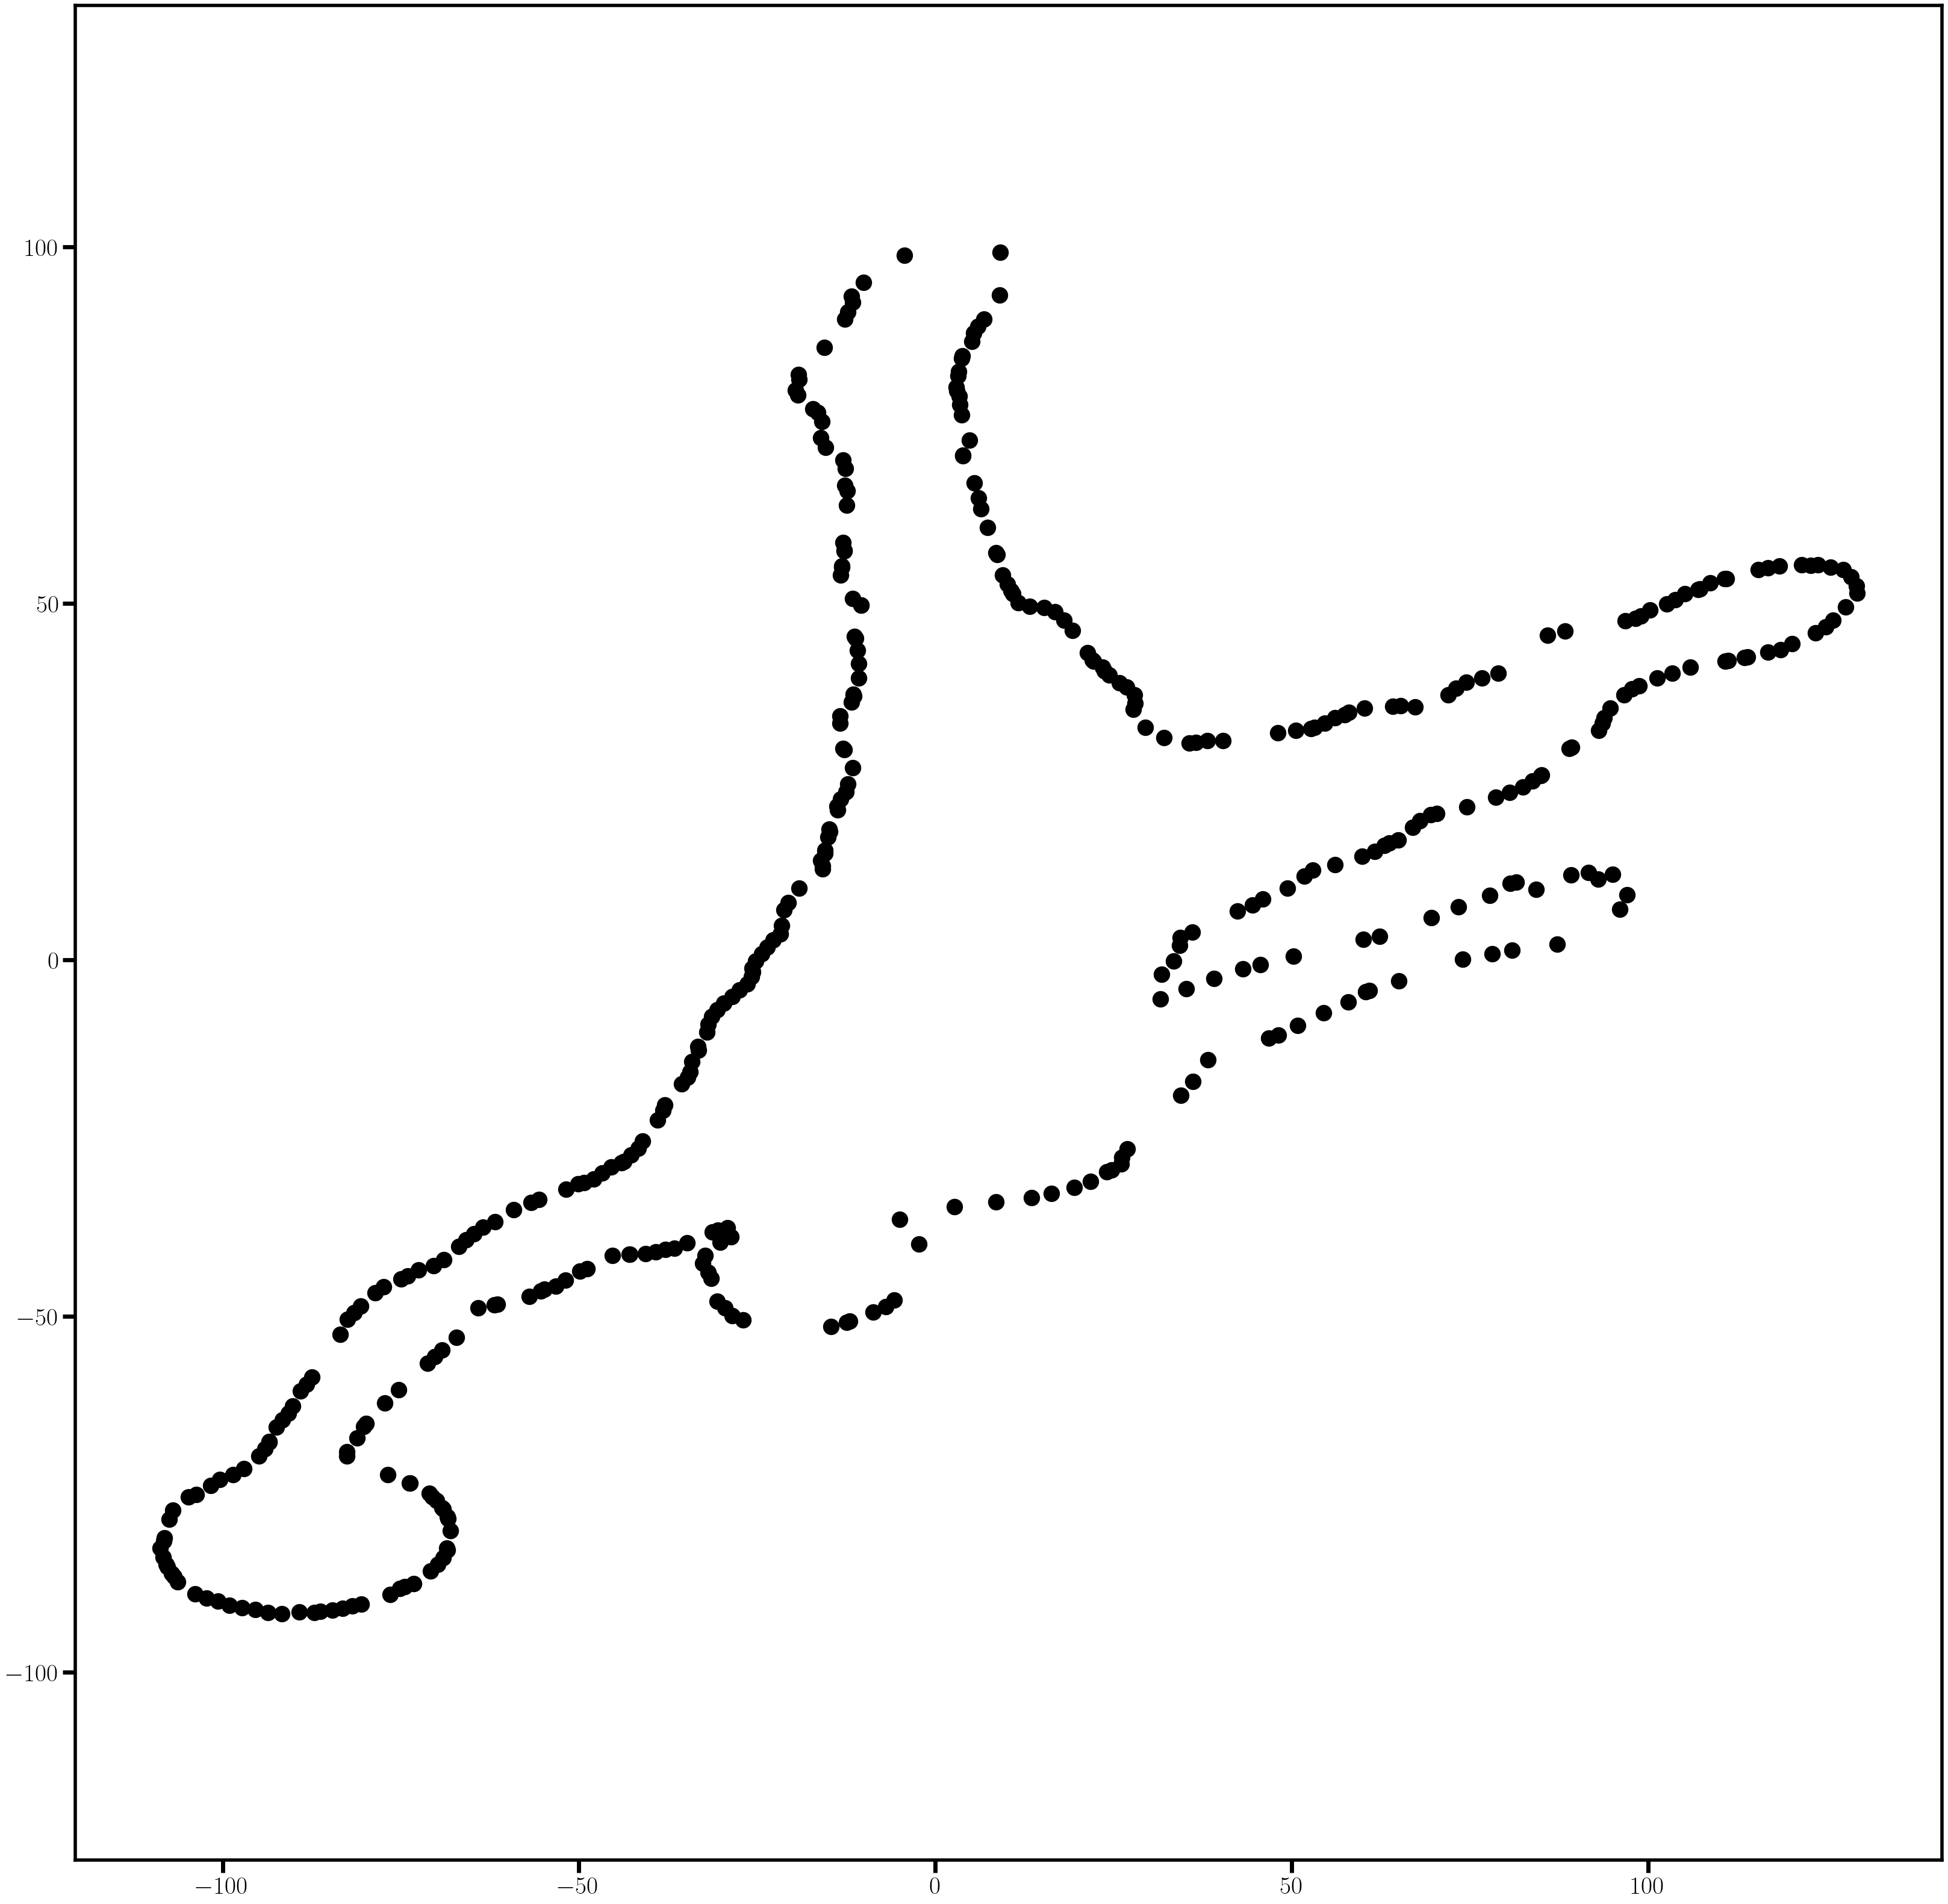

In [19]:
figsize=(40, 40)
fig, ax = matplotlib.pyplot.subplots(nrows=1, ncols=1, figsize=figsize)
curve = benchmark_0_5.planar_curves[7]
curve.plot_scattered_curve(ax=ax, cmap=None, color='#000000', point_size=350)
fig.savefig(f"C:/Users/Roy/OneDrive - Technion/Thesis/SSVM/basketball.svg")
matplotlib.pyplot.show()

In [10]:
# comparator = PlanarCurvesApproximatedSignatureComparator(
#     model=model,
#     supporting_points_count=supporting_points_count,
#     device=device)
#
# collections = ['basketball', 'bats', 'birds', 'branches', 'bunnies', 'butterflies', 'cacti', 'cats', 'chickens', 'clouds', 'deers', 'dogs', 'fishes', 'flames', 'flies', 'fruits', 'glasses', 'hearts', 'horses', 'insects', 'jogging', 'leaves', 'monkeys', 'mustaches', 'pieces', 'profiles', 'rats', 'shapes', 'shields', 'signs', 'spiders', 'trees', 'whales', 'wings']
#
# shape_matching_evaluator = PlanarCurvesShapeMatchingEvaluator(
#     log_dir_path=Path("C:/deep-signature-data-new/notebooks_output"),
#     num_workers=16,
#     curves_count_per_collection=30,
#     curve_collections_file_names=collections,
#     benchmark_dir_path=Path('C:/deep-signature-data-new/curves/benchmark/2023-01-07-10-12-19'),
#     sampling_ratios=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#     multimodalities=[10],
#     group_names=[group_name],
#     planar_curves_signature_comparator=comparator)
#
# shape_matching_evaluator.start()
# shape_matching_evaluator.join()
#
# print(shape_matching_evaluator.shape_matching_df)
# shape_matching_evaluator.shape_matching_df.to_csv("C:/deep-signature-data-new/notebooks_output/output.csv")